In [120]:
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import time

In [ ]:
#data points
#pe
#forward pe

In [123]:

end = dt.datetime(2020,5,30)
start = dt.datetime(2005,1,1)

def ticker_df(ticker, start, end):
    source = 'yahoo'
    df = web.DataReader(ticker, source, start, end)
    return df.drop(['High', 'Low', 'Open', 'Adj Close'], axis = 1)

SPY = ticker_df('SPY', start, end)
IWM = ticker_df('IWM', start, end)
QQQ = ticker_df('QQQ', start, end)
VXX = ticker_df('VXX', start, end)

In [124]:
# generate features / technical indicators functions for price action

## RSI
def change_val(stock_df):
    A = []
    for i in range(len(stock_df)):
        A.append(stock_df['Close'][i]-stock_df['Close'][i-1])
    A[0]=0
    return(A)

def gain(A):
    B=A.copy()
    for i in range(len(B)):
        if B[i]<0:
            B[i]=0
    return(B)

def loss(A):
    C=A.copy()
    for i in range(len(C)):
        if C[i]>0:
            C[i]=0
        else:
            C[i] = abs(C[i])
    return(C)

def RS_Val(gain,loss,n):
    D=[0]*len(gain)
    for i in range(len(D)-n):
        D[i+n-1]= sum(gain[i:i+n])/sum(loss[i:i+n])
    return(D)

def RSI(RSV):
    E=[0]*len(RSV)
    for i in range(len(E)):
        E[i]=100-100/(1+RSV[i])
    return(E)
#returns list of  RSI over n periods
def get_RSI(stock_df,n):
    A = change_val(stock_df)
    B = gain(A)
    C = loss(A)
    RSV = RS_Val(B,C,n)
    return(RSI(RSV))

##SMA, returns list of simple moving average over n periods
def get_SMA(stock_df,n):
    A = [0]*len(stock_df)
    for i in range(len(stock_df)-n+1):
        A[i+n-1] = np.mean(list(stock_df['Close'][i:i+n]))
    return(A)

#EMA, returns list of exponential moving average over n periods
def get_EMA(stock_df,n):
    mult = 2/(n+1)
    A = [0]*len(stock_df)
    A[n-1] = get_SMA(stock_df,n)[n-1]
    for i in range(n-1,len(stock_df)-1):
        A[i+1] = A[i]+(stock_df['Close'][i]-A[i])*mult
    return(A)

#pct change close price
def close_change_pct(stock_df):
    A = [0]*len(stock_df)
    for i in range(len(stock_df)-1):
        A[i+1] = (stock_df['Close'][i+1]-stock_df['Close'][i])/stock_df['Close'][i]
    return(A)

# get functions for volume action
def volm_change_pct(stock_df):
    A = [0]*len(stock_df)
    for i in range(len(stock_df)-1):
        A[i+1] = (stock_df['Volume'][i+1]-stock_df['Volume'][i])/stock_df['Volume'][i]
    return(A)


In [125]:
def consol_df(stock_df):
    n1 = 9
    n2 = 12
    n3 = 26
    stock_df['RSI'] = get_RSI(stock_df,n1)
    stock_df['pct change price'] = val_change_pct(stock_df)
    stock_df['12 EMA'] = get_EMA(stock_df,n2)
    stock_df['26 EMA'] = get_EMA(stock_df,n3)
    return(stock_df)[n3-1:len(stock_df)]


In [135]:
end = dt.datetime(2020,6,20)
start = dt.datetime(2010,1,1)

consol_df(ticker_df('QQQ', start, end)).to_csv('QQQ 2010-1-1 to 2020-6-20.csv')


c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


In [132]:
QQQ_prep.to_csv('QQQ_2005-02-08_to_2020-05-29.csv')

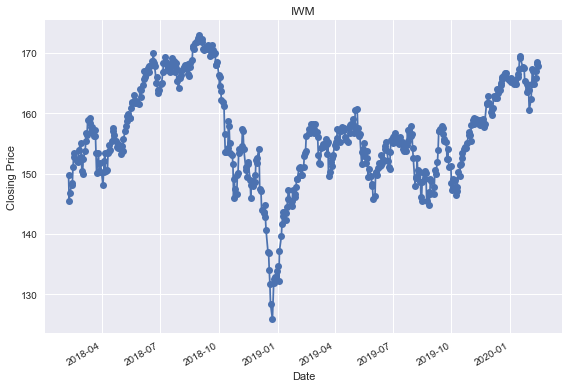

In [118]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.style.use('seaborn')
data = IWM_prep

price_date = list(data.index)
price_close = data['Close']

plt.plot_date(price_date, price_close, linestyle='solid')

plt.gcf().autofmt_xdate()

plt.title('IWM')
plt.xlabel('Date')
plt.ylabel('Closing Price')

plt.tight_layout()

plt.show()